VAR + FC x2 with relu and norm: 1.34

VAR + FC x2 no relu and norm:

In [1]:
import atd2022
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import holoviews as hv
import pandas as pd
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError, MeanSquaredError
from utils.tools import dotdict
from var_forecaster import VarForecaster
from multi_forecaster import MultiForecaster
import torch
hv.extension("bokeh")
# pd.set_option('display.max_columns', None)
torch.cuda.is_available()
#torch.cuda.set_device(5)

ModuleNotFoundError: No module named 'driver'

In [ ]:
args = dotdict()
args.var = dotdict()
args.ET_CNN = dotdict()

args.model_list = ['var',
                   'ET_CNN'
                  ]
args.predict_len = 4

args.var.if_normalize = True
args.var.if_filter_constant = True
args.var.lag=10
args.var.predict_len = args.predict_len
args.var.if_round = True
args.var.seperate_train = False
args.var.error_threshold = 10

args.ET_CNN.if_scheduler = False
args.ET_CNN.if_filter_constant = True
args.ET_CNN.if_normalize = False
args.ET_CNN.use_gpu = True
args.ET_CNN.batch_size = 30
args.ET_CNN.train_epochs= 250
args.ET_CNN.lr = 0.01
args.ET_CNN.history_len = 5
args.ET_CNN.predict_len = 1

In [ ]:
data = atd2022.io.read_csv()

In [ ]:
# Load data
truth = atd2022.io.read_csv()

# Subset the data for the sake of making this fast.
# Remove if you want to run the example on the entire dataset.
truth = truth.head(108)

# Experiment Parameters
window = 100
num_predict = 4
gap = 0
slide = 1

# Create a dataset `Splitter` object for generating train/test splits
splitter = atd2022.backtest.Splitter(
    
    truth,
    window,
    num_predict,
    gap,
    slide,
    expanding=True,
)

In [ ]:
# Populate a list of models that support the `atd2022.forecasters.Forecaster` protocol
# with which will we generate historical forecasts
models = [
    MultiForecaster(args),
    atd2022.forecasters.PredictMeanForecaster(),
    atd2022.forecasters.PredictLastForecaster(),
    atd2022.forecasters.ExponentiallyWeightedMovingAverage()
]

# Compute historical forecasts for all models
predictions = [
    atd2022.backtest.historical_forecast(model, splitter, verbose=True)
    for model in models
]

In [6]:
 # Make a mapping of model names to the model's predictions
timeseries = {repr(model): pred for model, pred in zip(models, predictions)}
atd2022.viz.plot_series_nstep_panel({"Truth": truth}, timeseries)

Row
    [0] HSpacer()
    [1] HoloViews(DynamicMap, center=True, widget_location='right')
    [2] HSpacer()
    [3] Column
        [0] VSpacer()
        [1] WidgetBox
            [0] Select(margin=(20, 20, 5, 20), name='Region', options=['Aruba', 'Antigua and Bar...], value='Aruba', width=250)
            [1] Select(margin=(0, 20, 5, 20), name='Event', options=['MAKE PUBLIC STATEMENT', ...], value='MAKE PUBLIC STATEMENT', width=250)
            [2] DiscreteSlider(formatter='%d', margin=(5, 20, 20, 20), name='Step', options=OrderedDict([('0', ...]), value=0, width=250)
        [2] VSpacer()

Predictions Processed:   0%|          | 0/4 [00:00<?, ?it/s]

Predictions Processed:   0%|          | 0/16 [00:00<?, ?it/s]

,MeanAbsoluteScaledError,MeanSquaredError
<multi_forecaster.MultiForecaster object at 0x7fb060779fa0>,1.546576,79.450539
PredictMeanForecaster(),1.459343,74.146892
PredictLastForecaster(),1.680650,88.101617
ExponentiallyWeightedMovingAverage(span=3),1.591927,81.234780


MeanAbsoluteScaledError  \
model                                              n                            
<multi_forecaster.MultiForecaster object at 0x7... 0                 1.366146   
                                                   1                 1.549194   
                                                   2                 1.632734   
                                                   3                 1.638231   
ExponentiallyWeightedMovingAverage(span=3)         0                 1.210449   
                                                   1                 1.607165   
                                                   2                 1.743103   
                                                   3                 1.806993   
PredictLastForecaster()                            0                 1.136224   
                                                   1                 1.742717   
                                                   2                 1.937990   
                                                   3                 1.905667   
PredictMeanForecaster()                            0                 1.438947   
                                                   1                 1.432186   
                                                   2                 1.446583   
                                                   3                 1.519656   

                                                      MeanSquaredError  
model                                              n                    
<multi_forecaster.MultiForecaster object at 0x7... 0         68.369653  
                                                   1         78.312066  
                                                   2         81.922917  
                                                   3         82.340897  
ExponentiallyWeightedMovingAverage(span=3)         0         59.782868  
                                                   1         79.974515  
                                                   2         86.659919  
                                                   3         89.252260  
PredictLastForecaster()                            0         58.783469  
                                                   1         87.343716  
                                                   2         96.675974  
                                                   3         97.195540  
PredictMeanForecaster()                            0         69.110252  
                                                   1         71.046277  
                                                   2         71.629932  
                                                   3         74.645810

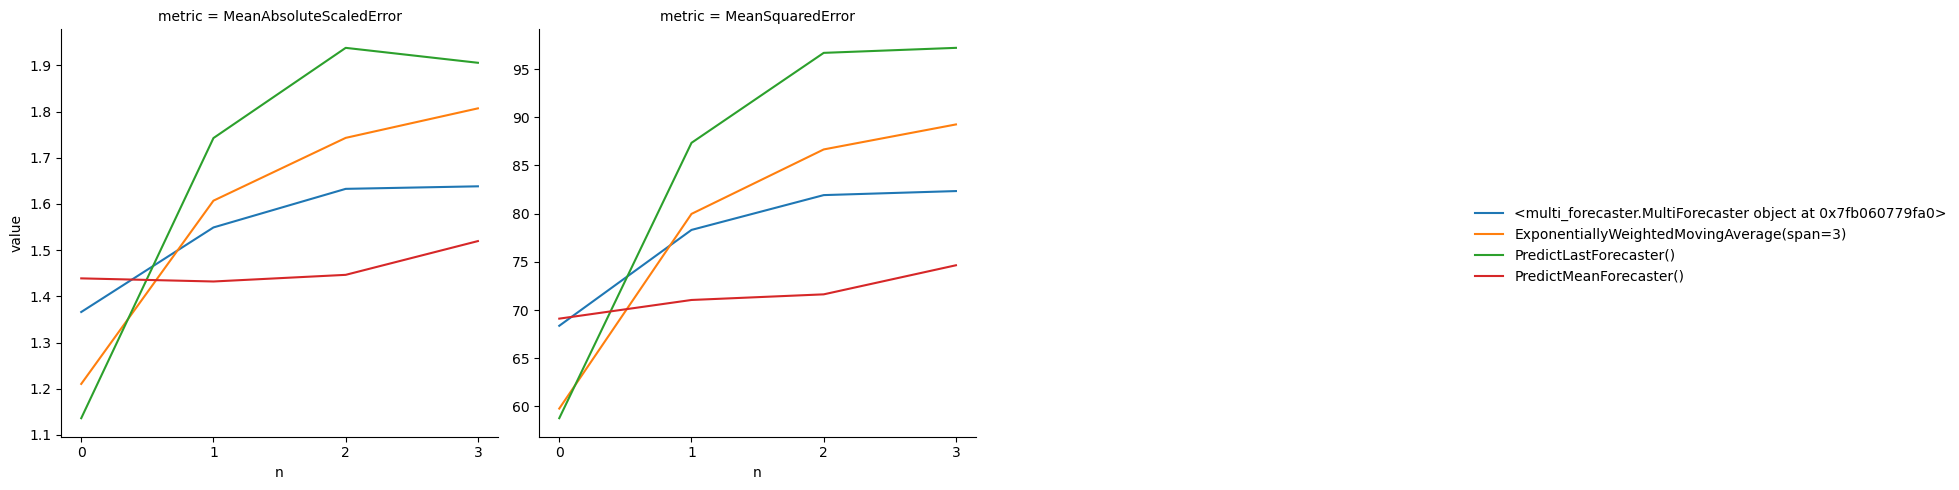

In [7]:
metric_functions = [
    MeanAbsoluteScaledError(),
    MeanSquaredError(square_root=True),
]

metrics_df = atd2022.metrics.compute_metrics(
    truth,
    predictions,
    metric_functions,
    models=models,
    train=truth,
    verbose=True,
)

metrics_n = atd2022.metrics.compute_nstep_metrics(
    truth,
    predictions,
    metric_functions,
    models=models,
    train=truth,
    verbose=True,
)
display(metrics_df)
display(metrics_n)
display(atd2022.viz.plot_nstep_metrics(metrics_n))